# Introducing the Keras Functional API

## Learning objectives
  1. Understand embeddings and how to create them with the preprocessing layer.
  2. Understand Deep and Wide models and when to use them.
  3. Understand the Keras functional API and how to build a deep and wide model with it.

## Introduction

In the last notebook, we learned about the Keras Sequential API. The [Keras Functional API](https://www.tensorflow.org/guide/keras#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).


In [1]:
#!pip install tensorflow-gpu
!pip install tensorflow-io --user

  Obtaining dependency information for tensorflow-io from https://files.pythonhosted.org/packages/74/e6/e1b9e62dad8eeb509c842d76363ed4a34cd17e2b751610cc993e57b14f2c/tensorflow_io-0.34.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 44.5 MB/s eta 0:00:00:00:0100:01


**Note:** Restart the kernel by clicking **Kernel > Restart Kernel > Restart**.

Start by importing the necessary libraries for this lab.

In [1]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    CategoryEncoding,
    Concatenate,
    Dense,
    Discretization,
    Embedding,
    Flatten,
    Input,
)
from tensorflow.keras.layers.experimental.preprocessing import HashedCrossing

print(tf.__version__)

2023-10-16 03:27:22.077374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 03:27:23.409231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 03:27:23.409367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
%matplotlib inline

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [3]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter  123590 Oct 15 11:55 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 2186310 Oct 15 11:55 ../data/taxi-traffic-test.csv
-rw-r--r-- 1 jupyter jupyter 9713118 Oct 15 11:55 ../data/taxi-traffic-train.csv
-rw-r--r-- 1 jupyter jupyter 2036826 Oct 15 11:55 ../data/taxi-traffic-valid.csv
-rw-r--r-- 1 jupyter jupyter  579055 Oct 15 11:55 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter  123114 Oct 15 11:55 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

In [5]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Build model in Keras

In [7]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

inputs = {
    colname: Input(name=colname, shape=(1,), dtype="float32")
    for colname in INPUT_COLS
}

In [9]:
inputs

{'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
 'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
 'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
 'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
 'passenger_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'passenger_count')>}

Then, we can connect each layers one by one

In [10]:
dnn_hidden_units = [32, 8]
NBUCKETS = 16

latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

# Bucketization with Discretization layer
plon = Discretization(lonbuckets, name="plon_bkt")(inputs["pickup_longitude"])
plat = Discretization(latbuckets, name="plat_bkt")(inputs["pickup_latitude"])
dlon = Discretization(lonbuckets, name="dlon_bkt")(inputs["dropoff_longitude"])
dlat = Discretization(latbuckets, name="dlat_bkt")(inputs["dropoff_latitude"])

# Feature Cross with HashedCrossing layer
p_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="p_fc")((plon, plat))
d_fc = HashedCrossing(num_bins=NBUCKETS * NBUCKETS, name="d_fc")((dlon, dlat))
pd_fc = HashedCrossing(num_bins=NBUCKETS**4, name="pd_fc")((p_fc, d_fc))

# Embedding with Embedding layer
pd_embed = Embedding(input_dim=NBUCKETS**4, output_dim=10, name="pd_embed")(
    pd_fc
)

# Concatenate and define inputs for deep network
deep = Concatenate(name="deep_input")(
    [
        inputs["pickup_longitude"],
        inputs["pickup_latitude"],
        inputs["dropoff_longitude"],
        inputs["dropoff_latitude"],
        Flatten(name="flatten_embedding")(pd_embed),
    ]
)

# Add hidden Dense layers
for i, num_nodes in enumerate(dnn_hidden_units, start=1):
    deep = Dense(num_nodes, activation="relu", name=f"hidden_{i}")(deep)

# Onehot Encoding with CategoryEncoding layer
p_onehot = CategoryEncoding(num_tokens=NBUCKETS * NBUCKETS, name="p_onehot")(
    p_fc
)
d_onehot = CategoryEncoding(num_tokens=NBUCKETS * NBUCKETS, name="d_onehot")(
    d_fc
)
pd_onehot = CategoryEncoding(num_tokens=NBUCKETS**4, name="pd_onehot")(pd_fc)

# Concatenate and define inputs for wide network
wide = Concatenate(name="wide_input")([p_onehot, d_onehot, pd_onehot])

# Concatenate wide & deep networks
concat = Concatenate(name="concatenate")([deep, wide])

# Define the final output layer
output = Dense(1, activation=None, name="output")(concat)

2023-10-16 03:30:23.849391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 03:30:23.849442: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-16 03:30:23.849475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5dc109c77294): /proc/driver/nvidia/version does not exist
2023-10-16 03:30:23.849777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

Then, we'll define our custom RMSE evaluation metric

In [11]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

Next, we can define the input and output of the entire model, and compile it.  We can also use `plot_model` to see a diagram of the model we've created.

In [12]:
model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=[rmse])

In [13]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Next, we'll set up our training variables, create our datasets for training and validation, and train our model.

(We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.)

In [14]:
BATCH_SIZE = 100
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-train*", batch_size=BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="../data/taxi-valid*", batch_size=BATCH_SIZE, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

In [15]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "./taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True)  # start fresh each time

# TODO
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(OUTDIR)],
)

Epoch 1/50
10/10 [==============================] - 4s 133ms/step - loss: 252.5282 - rmse: 15.6222 - val_loss: 221.0240 - val_rmse: 14.7200
Epoch 2/50
10/10 [==============================] - 0s 48ms/step - loss: 194.8392 - rmse: 13.8774 - val_loss: 211.8965 - val_rmse: 14.4183
Epoch 3/50
10/10 [==============================] - 0s 52ms/step - loss: 190.5487 - rmse: 13.7327 - val_loss: 206.5255 - val_rmse: 14.0554
Epoch 4/50
10/10 [==============================] - 0s 51ms/step - loss: 157.0633 - rmse: 12.4192 - val_loss: 176.3599 - val_rmse: 12.9453
Epoch 5/50
10/10 [==============================] - 0s 46ms/step - loss: 140.4208 - rmse: 11.6764 - val_loss: 173.2200 - val_rmse: 12.8148
Epoch 6/50
10/10 [==============================] - 0s 44ms/step - loss: 122.5882 - rmse: 10.9008 - val_loss: 113.0567 - val_rmse: 10.4808
Epoch 7/50
10/10 [==============================] - 0s 44ms/step - loss: 90.4254 - rmse: 9.3181 - val_loss: 111.9475 - val_rmse: 10.3396
Epoch 8/50
10/10 [==========

Just as before, we can examine the history to see how the RMSE changes through training on the train set and validation set. 

<Axes: >

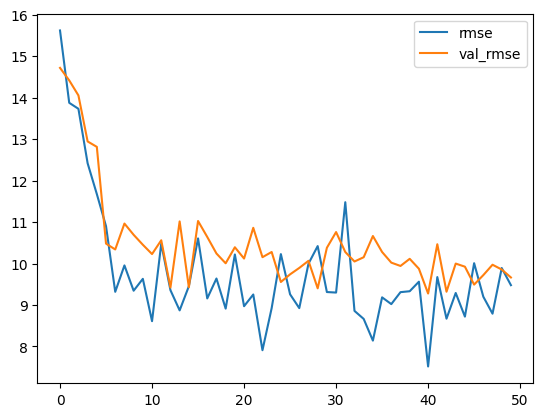

In [16]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()